<a href="https://colab.research.google.com/github/timaaos/Craft.py/blob/master/scaleupimage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup


In [1]:
!nvidia-smi

Wed Jul  6 18:00:04 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!pip install --upgrade rudalle==1.1.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 3.1 MB/s 
     |████████████████████████████████| 79 kB 7.8 MB/s 
     |████████████████████████████████| 2.8 MB 61.6 MB/s 
     |████████████████████████████████| 4.4 MB 12.7 MB/s 
     |████████████████████████████████| 66 kB 5.0 MB/s 
     |████████████████████████████████| 45 kB 3.5 MB/s 
     |████████████████████████████████| 60.3 MB 1.2 MB/s 
     |████████████████████████████████| 1.7 MB 53.8 MB/s 
     |████████████████████████████████| 244 kB 57.2 MB/s 
     |████████████████████████████████| 58 kB 6.4 MB/s 
     |████████████████████████████████| 585 kB 70.6 MB/s 
     |████████████████████████████████| 596 kB 75.9 MB/s 
     |████████████████████████████████| 117 kB 64.7 MB/s 
     |████████████████████████████████| 140 kB 71.1 MB/s 
     |████████████████████████████████| 419 kB 76.3 MB/s 
     |████████████████████████████████| 1

In [71]:
#@title Текст заголовка по умолчанию
# -*- coding: utf-8 -*-
import os

import torch
from huggingface_hub import hf_hub_url, cached_download
from rudalle.dalle import MODELS
from rudalle.dalle.model import DalleModel
from rudalle.dalle.fp16 import FP16Module


MODELS.update({
    'Surrealist_XL': dict(
        hf_version='v3',
        description='Surrealist is 1.3 billion params model from the family GPT3-like, '
                    'that was trained on surrealism and Russian.',
        model_params=dict(
            num_layers=24,
            hidden_size=2048,
            num_attention_heads=16,
            embedding_dropout_prob=0.1,
            output_dropout_prob=0.1,
            attention_dropout_prob=0.1,
            image_tokens_per_dim=32,
            text_seq_length=128,
            cogview_sandwich_layernorm=True,
            cogview_pb_relax=True,
            vocab_size=16384 + 128,
            image_vocab_size=8192,
        ),
        repo_id='shonenkov-AI/rudalle-xl-surrealist',
        filename='pytorch_model.bin',
        authors='shonenkovAI',
        full_description='',
    )
})


def get_rudalle_model(name, pretrained=True, fp16=False, device='cpu', cache_dir='/tmp/rudalle', **model_kwargs):
    assert name in MODELS

    if fp16 and device == 'cpu':
        print('Warning! Using both fp16 and cpu doesnt support. You can use cuda device or turn off fp16.')

    config = MODELS[name].copy()
    config['model_params'].update(model_kwargs)
    model = DalleModel(device=device, **config['model_params'])
    if pretrained:
        cache_dir = os.path.join(cache_dir, name)
        config_file_url = hf_hub_url(repo_id=config['repo_id'], filename=config['filename'])
        cached_download(config_file_url, cache_dir=cache_dir, force_filename=config['filename'])
        checkpoint = torch.load(os.path.join(cache_dir, config['filename']), map_location='cpu')
        model.load_state_dict(checkpoint)
    if fp16:
        model = FP16Module(model)
    model.eval()
    model = model.to(device)
    if config['description'] and pretrained:
        print(config['description'])
    return model
from rudalle.pipelines import generate_images, show, super_resolution
from rudalle.image_prompts import ImagePrompts
from rudalle import get_rudalle_model, get_tokenizer, get_vae, get_realesrgan
from rudalle.utils import seed_everything
device = 'cuda'
dalle = get_rudalle_model('Surrealist_XL', fp16=True, device=device)
realesrgan = get_realesrgan('x4', device=device)
tokenizer = get_tokenizer()
vae = get_vae().to(device)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/file_download.py:563: FutureWarning: `cached_download` is the legacy way to download files from the HF hub, please consider upgrading to `hf_hub_download`
  FutureWarning,


Surrealist is 1.3 billion params model from the family GPT3-like, that was trained on surrealism and Russian.
x4 --> ready
tokenizer --> ready
Working with z of shape (1, 256, 32, 32) = 262144 dimensions.
vae --> ready


# Settings

In [82]:
pr = "\u0441\u0432\u0438\u043D\u044C\u044F" #@param {type: "string"}
seed =  23456#@param {type: "integer"}
qual = 1024 #@param {type:"slider", min:256, max:2048, step:64}
borders_dirsize = 26 #@param {type: "integer"}
zoomout_pixels = 50 #@param {type: "integer"}

# Generate first image


In [64]:
seed_everything(seed)
pil_images = []
scores = []
for top_k, top_p, images_num in [
    (qual, 0.995, 1),
]:
    _pil_images, _scores = generate_images(pr, tokenizer, dalle, vae, top_k=top_k, images_num=images_num, bs=8, top_p=top_p)
    pil_images += _pil_images
    scores += _scores
pil_images[0].save("result.png")
show(pil_images,1)

  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:85: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


KeyboardInterrupt: ignored

# Scaleout

In [84]:
from google.colab import files
from PIL import Image
import os

mode = 1 # mode: 0 - upload file, 1 - use result.png

name = ""
if mode == 0:
  uploaded = files.upload()
  name = next(iter(uploaded))
elif mode == 1:
  name = "result.png"
print(f"Formatting file {name} for rudalle")
image = Image.open(name)
imb = Image.new("RGBA",(image.size[0]+zoomout_pixels*2,image.size[1]+zoomout_pixels*2),(255,0,0,0))
imb.paste(image,(zoomout_pixels,zoomout_pixels))
imb.save("toPrompt.png","PNG")
os.remove(name)


Saving 1.png to 1.png
Formatting file 1.png for rudalle


In [36]:
pr = "пустыня" 

In [87]:
from collections import defaultdict
from PIL import Image
import torch
#qual += 256
print(f"Generating {pr} with quality {qual}, seed {seed}")
toPrompt = Image.open("toPrompt.png").resize((256, 256)).convert("RGBA")
oToPrompt = toPrompt
topP = 0.995
pt_items = {
    'topr': {
        'prompt': ImagePrompts(
            toPrompt, 
            {'up': 0, 'left': 0, 'right': 0, 'down': borders_dirsize}, 
            vae, 
            torch.device('cuda')
        ),
        'texts': [
            pr
        ]
    }
}

all_images = defaultdict(list)

for name, item in pt_items.items():
    seed_everything(seed)
    for text in item['texts']:
        pil_images = []
        for top_k, top_p, images_num in [
            (qual, topP, 1),
        ]:
            _pil_images, _ = generate_images(
                text,
                tokenizer,
                dalle,
                vae,
                top_k=top_k,
                images_num=images_num,
                image_prompts=item['prompt'],
                top_p=top_p
            )
            pil_images += _pil_images
        all_images[name] += pil_images
all_images["topr"][0].save("result.png","PNG")
toPrompt = Image.open("result.png").resize((256, 256)).convert("RGBA")

pt_items2 = {
    'topr': {
        'prompt': ImagePrompts(
            toPrompt, 
            {'up': 0, 'left': 0, 'right': borders_dirsize, 'down': 0}, 
            vae, 
            torch.device('cuda')
        ),
        'texts': [
            pr
        ]
    }
}
toPrompt = Image.open("result.png").resize((256, 256)).convert("RGBA")
all_images = defaultdict(list)

for name, item in pt_items2.items():
    seed_everything(seed)
    for text in item['texts']:
        pil_images = []
        for top_k, top_p, images_num in [
            (qual, topP, 1),
        ]:
            _pil_images, _ = generate_images(
                text,
                tokenizer,
                dalle,
                vae,
                top_k=top_k,
                images_num=images_num,
                image_prompts=item['prompt'],
                top_p=top_p
            )
            pil_images += _pil_images
        all_images[name] += pil_images
all_images["topr"][0].save("result.png","PNG")
pt_items3 = {
    'topr': {
        'prompt': ImagePrompts(
            toPrompt, 
            {'up': 0, 'left': borders_dirsize, 'right': 0, 'down': 0}, 
            vae, 
            torch.device('cuda')
        ),
        'texts': [
            pr
        ]
    }
}
all_images = defaultdict(list)

for name, item in pt_items3.items():
    seed_everything(seed)
    for text in item['texts']:
        pil_images = []
        for top_k, top_p, images_num in [
            (qual, topP, 1),
        ]:
            _pil_images, _ = generate_images(
                text,
                tokenizer,
                dalle,
                vae,
                top_k=top_k,
                images_num=images_num,
                image_prompts=item['prompt'],
                top_p=top_p
            )
            pil_images += _pil_images
        all_images[name] += pil_images
all_images["topr"][0].save("result.png","PNG")
toPrompt = Image.open("result.png").resize((256, 256)).convert("RGBA")
pt_items4 = {
    'topr': {
        'prompt': ImagePrompts(
            toPrompt, 
            {'up': borders_dirsize, 'left': 0, 'right': 0, 'down': 0}, 
            vae, 
            torch.device('cuda')
        ),
        'texts': [
            pr
        ]
    }
}
all_images = defaultdict(list)

for name, item in pt_items4.items():
    seed_everything(seed)
    for text in item['texts']:
        pil_images = []
        for top_k, top_p, images_num in [
            (qual, topP, 1),
        ]:
            _pil_images, _ = generate_images(
                text,
                tokenizer,
                dalle,
                vae,
                top_k=top_k,
                images_num=images_num,
                image_prompts=item['prompt'],
                top_p=top_p
            )
            pil_images += _pil_images
        all_images[name] += pil_images
all_images["topr"][0].save("result.png","PNG")
s = super_resolution(all_images["topr"],realesrgan)
s[0].save("resultU.png","PNG")

Generating свинья with quality 1024, seed 23456


  0%|          | 0/1024 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/rudalle/dalle/model.py:85: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dtype=torch.long, device=self.device) // self.image_tokens_per_dim


  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

  0%|          | 0/1024 [00:00<?, ?it/s]

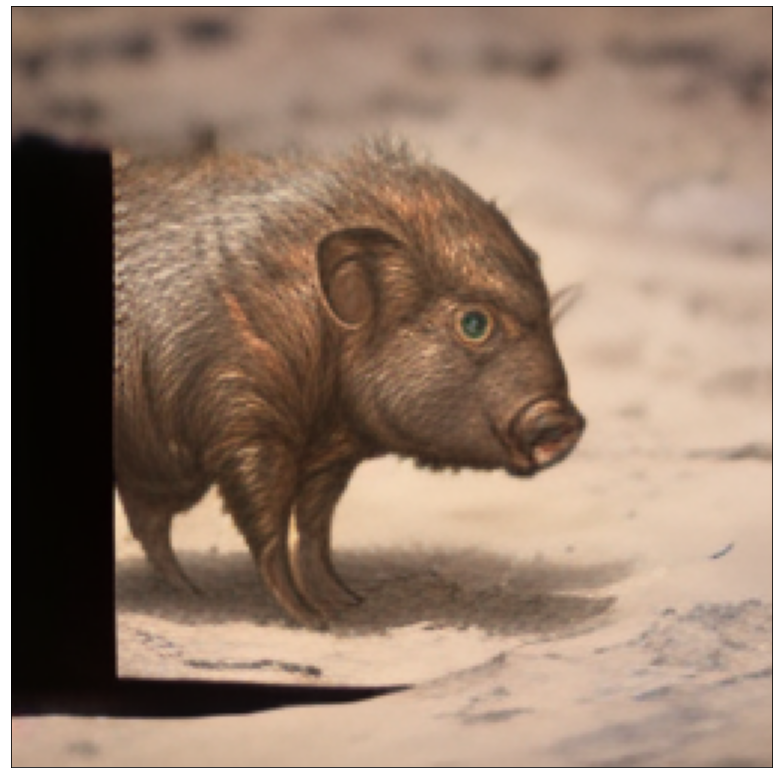

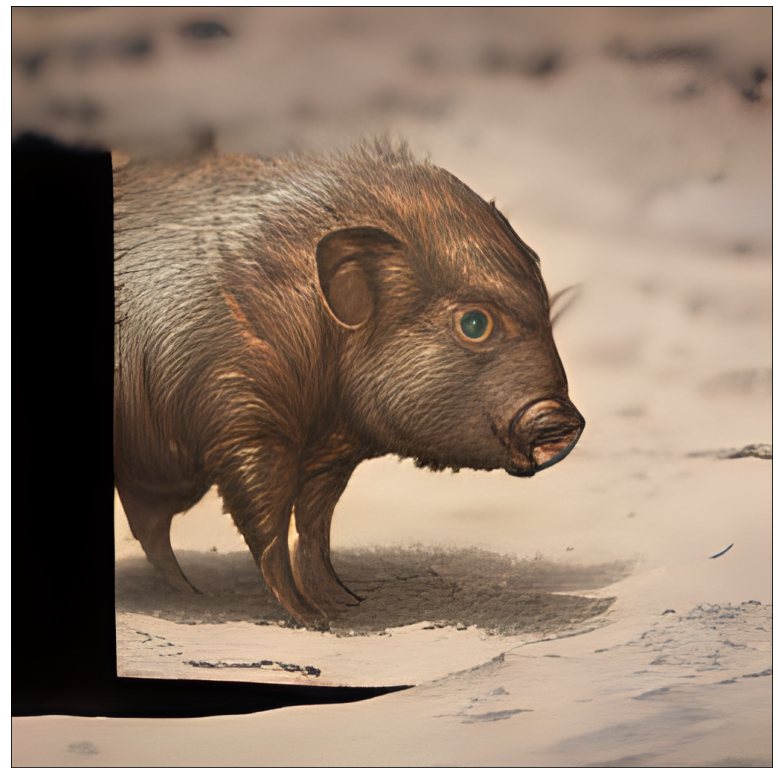

In [88]:
show(all_images['topr'], 1)
show(s, 1)